### Linear Models Coefficients Interpretation and Importance. What Might go Wrong?
It's trickier to deal with linear models in terms of data preprocessing since the data has to fulfill certain requirements (e.g. has linear dependency, no missing values,  the same scale, etc.). I think **we all use the main/default plot to get feature importances of a model.** For linear models we can simply call `coef_` attribute to get feature weights and this weight will show us the importance of a feature (e.g. big weight means that it has bigger impact on the target variable and vice versa). 

Although this approach is current we always should keep in mind some requirements to trust such plot/coefficients. Let's have a look at an example and point at problems that arise when **either the linear model is not appropriate to describe the dataset, or when features are correlated.**

### What Does Coefficients of Linear Models Tell?
For example, for `Linear Regression` coeeficients represent the relationship between the given feature and the target, assuming that all the other features remain constant. Since the main idea is to learn we will use a simple dataset "Current Population Survey" to predict wage.

In [86]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import median_absolute_error

In [5]:
# get the data
survey = fetch_openml(data_id=534, as_frame=True)

X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


- Dataset includes both `numerical` and `categorical` features

In [7]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


In [8]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [10]:
# make train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Important**
- Since test data is assumed as unseen/unknow data, **we always perform EDA on train data**, not entirely on the whole dataset

Let's have a look at features distributions and their pairwise relationship. Use only numerical features.

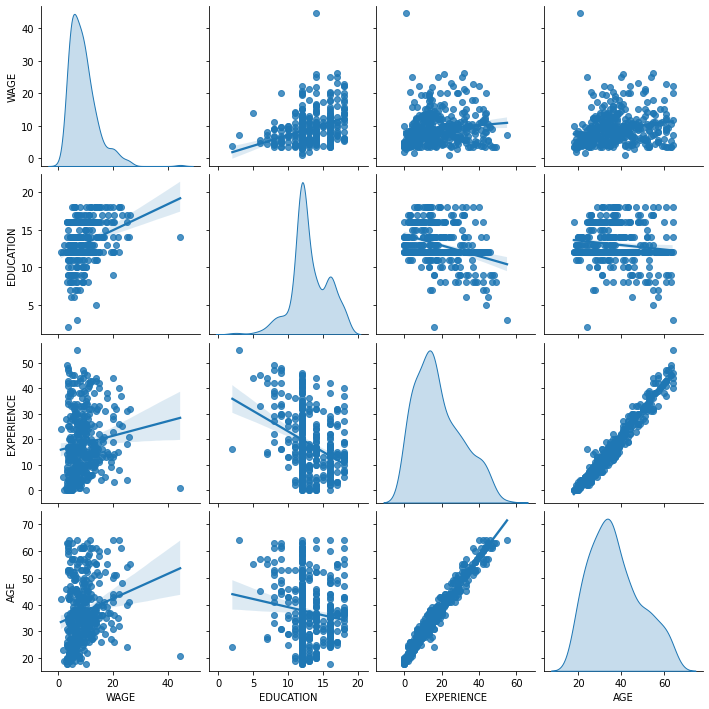

In [11]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

**Insights**
- Wage has long tail (presence of outliers). We will applly logarithm transformation to make the distribution more normal (**linear models like when data is normally distributed**)
- Dependent features indeed have more or less linear dependence
- **Experience and Age are highly/perfectly correlated**

We already know that multicollinearity is bad, especially for linear models. This time we will go through different experiments to prove it.

In [ ]:
# Ln transformation example 

**ML Pipeline Definition**

Pipeline modules provides more flexibility, that's why we are going to use it, to use it we need to define preprocessing for different features (numerical, categorical, etc.). We cannot simply pass text into linear models, we need to encode it. 
- Categorical Features -> Dummy Variables (One Hot Encoding with n-1 feature per category)
- **No scaling for now** -> we need it to demonstrate why scaling matters

In [16]:
categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10),
        func=np.log10, # logaritm transformation
        inverse_func=sp.special.exp10 # inverse transformation from logarithm to get actual value
    ),
)

In [17]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

**Metric Definition**
- To test the model performace we will use `Median Absolute Error`. Any other metric can be chosen

In [50]:
y_pred = model.predict(X_test)

mae_train = median_absolute_error(y_train, model.predict(X_train))
mae_test = median_absolute_error(y_test, y_pred)

scores = {
    "MedAE (Train)": f"{mae_train:.2f} $/hour",
    "MedAE (Test)": f"{mae_test:.2f} $/hour",
}

print(scores)

{'MedAE (Train)': '2.14 $/hour', 'MedAE (Test)': '2.22 $/hour'}


C:\Users\vlad\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\vlad\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


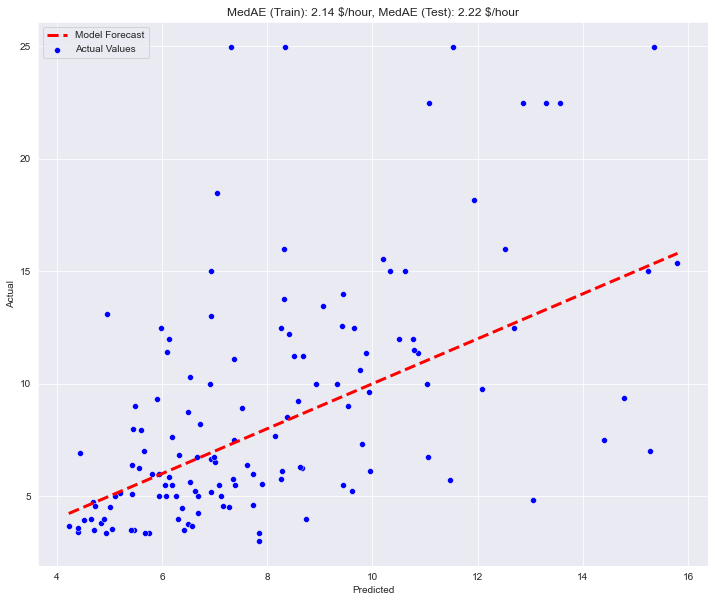

In [59]:
plt.figure(figsize=(12,10))
sns.set_style('darkgrid')
sns.scatterplot(y_pred, y_test, color='blue', label='Actual Values')
sns.lineplot(y_pred, y_pred, linestyle='--', color='red', linewidth=3, label='Model Forecast')
plt.title(f"MedAE (Train): {mae_train:.2f} \$/hour, MedAE (Test): {mae_test:.2f} \$/hour")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend();

### Interpreting Coefficients: Scale Matters

In [60]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
RACE_Hispanic,-0.013520
RACE_Other,-0.009076
RACE_White,0.022593
OCCUPATION_Clerical,0.000080
OCCUPATION_Management,0.090563
OCCUPATION_Other,-0.025066
OCCUPATION_Professional,0.071999
OCCUPATION_Sales,-0.046601
OCCUPATION_Service,-0.091018
SECTOR_Construction,-0.000179


**Insights**
- We have an issue with a scale because features like `EDUCATION` and `Sex` are on different scale. `Sex` can be either 0 or 1 whereas `EDUCATION` has bigger scale. 
- We cannot compare the magnitude of different coefficients since the features have different natural scales, and hence value ranges, because of their different unit of measure. This is more visible if we plot the coefficients.

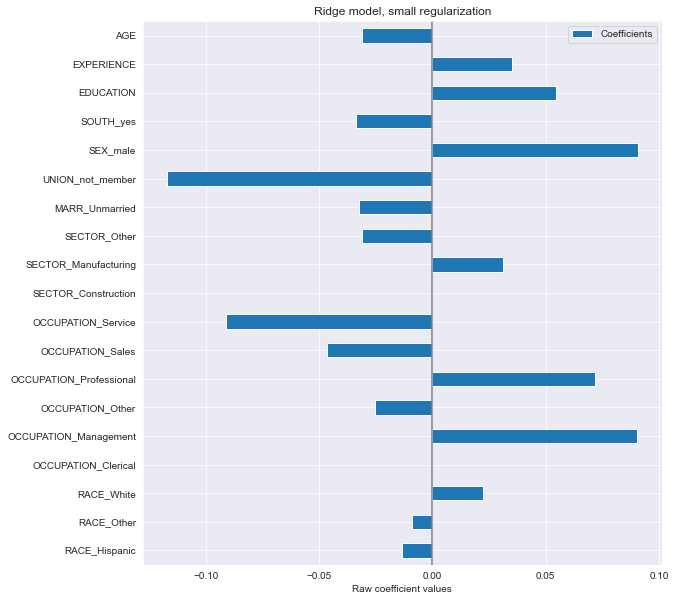

In [63]:
coefs.plot.barh(figsize=(12, 10))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

**Insights**
- From the plot above we see that the most important feature `UNION`. However, common sense tells that it should be `EXPERIENCE`
- Feature importance plot from above is misleading and can fool you. Some features varies on a small scale, while others (e.g. `AGE`) vary a lot more, several decades.

To highlight this issue and make it more visible, let's estimate and plot standard deviation of coefficients.

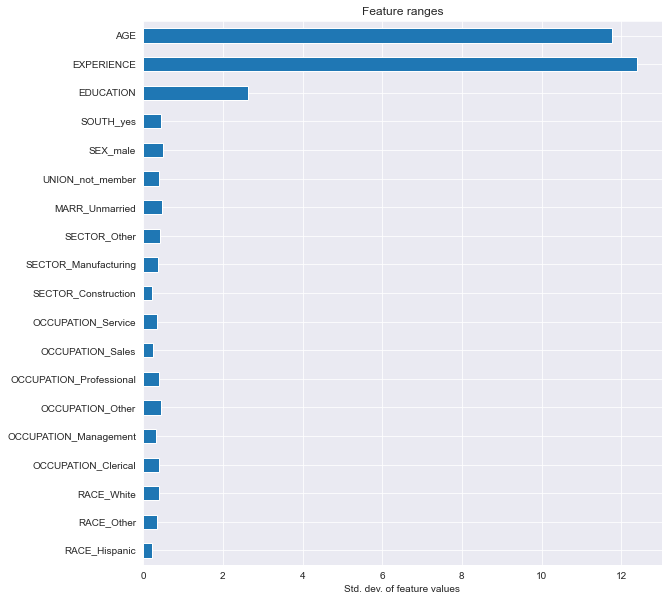

In [66]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(12, 10))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

**Insights**
- Features indeed have different `std`. For example, `AGE std` is almost 12 times bigger than `RACE std`

### Feature Scaling
One solution to put all the features on the same scale - multiply the coeeficients by the `std` of the related feature. Thus, **the greater the variance of a feature, the larger the weight of the corresponding coefficient**

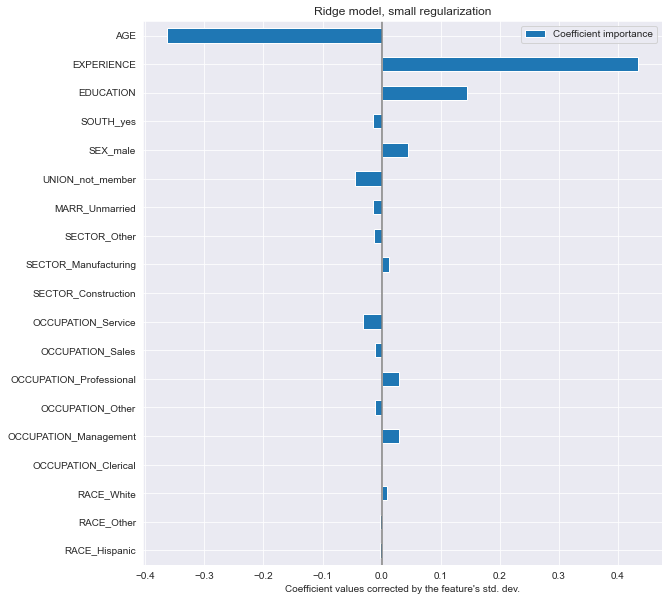

In [68]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(12, 10))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

**Insights**
- Features like `AGE, EXPERIENCE, EDUCATION` are the most important

### Checking the Variability of the Coeficients
It's always a good idea to check coefficients variability. **If coefficients vary significantly when changing the input dataset their robustness is not guaranteed, and they should probably be interpreted with caution.**

In [71]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

cv_model = cross_validate(
    model, X, y,
    cv=cv,
    return_estimator=True,
    n_jobs=-1
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names
)

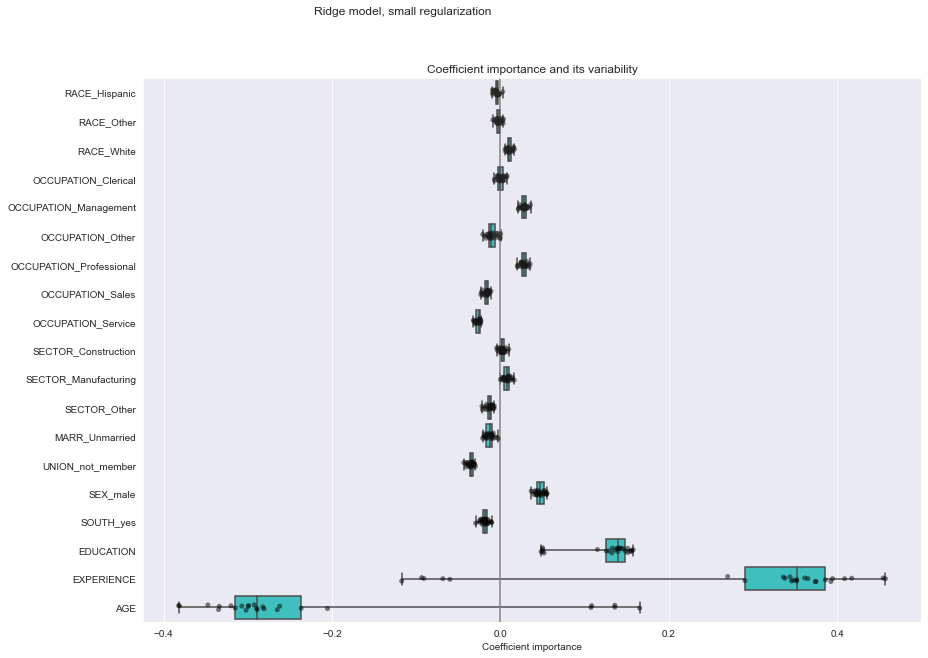

In [75]:
plt.figure(figsize=(18, 10))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

**Insights**
- Most of the features have small `std`. It's a good, we can trust them
- `AGE` and `EXPERIENCE` have large `std`. It's not good since these coefficients are the most important ones. What might be wrong with them?

### Multicollinearity Problem
If you remember, we have previously identified that `AGE` and `EXPERIENCE` are perfectly correlated. That's why we see such high coefficient variance. 

**Solution**
- Drop either `AGE` or `EXPERIENCE` from the training data
- Apply regularization

In [76]:
# solution A: drop one of the correlated features
column_to_drop = ["AGE"]

cv_model = cross_validate(
    model, X.drop(columns=column_to_drop), y,
    cv=cv,
    return_estimator=True,
    n_jobs=-1,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_
        * est[:-1].transform(X.drop(columns=column_to_drop).iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names[:-1],
)

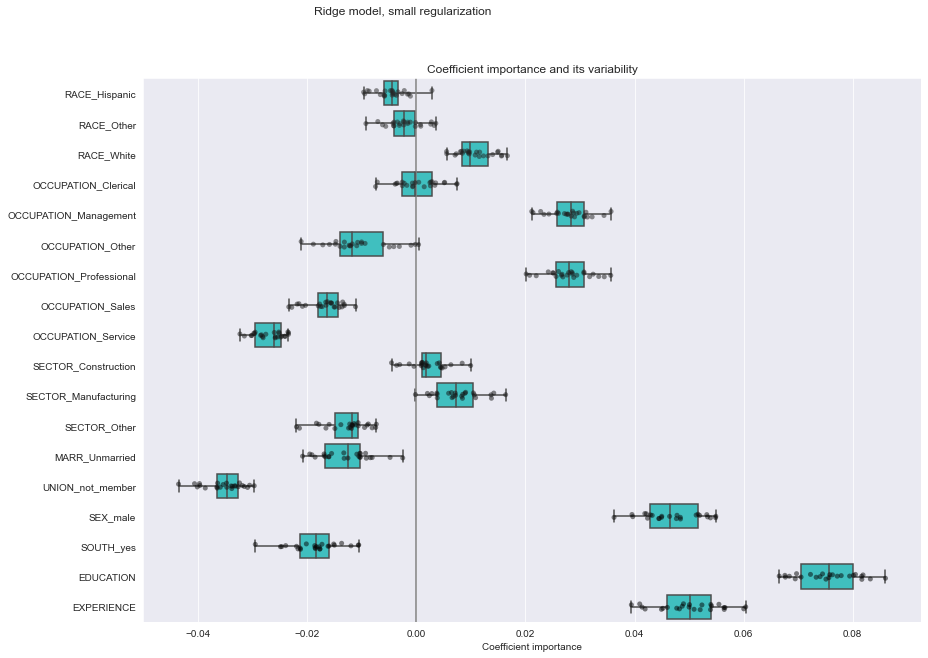

In [77]:
plt.figure(figsize=(18, 10))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

**Insights**
- It looks better now. All features have relatively small variance

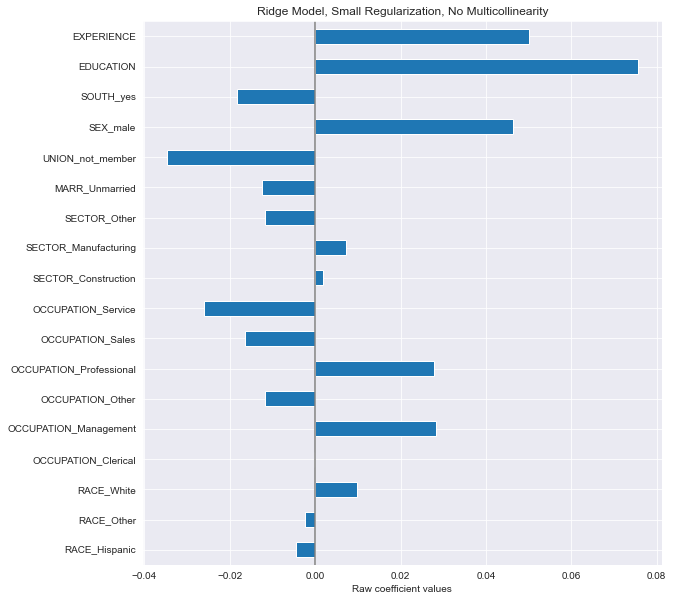

In [83]:
# let's check model weights again
coefs.median().plot.barh(figsize=(12, 10))
plt.title("Ridge Model, Small Regularization, No Multicollinearity")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

**Insights**
- The Feature Importance distribution looks the same (features order), only weights changeda bit. But since we are using median, we trsut them even more now

### Multicollinearity Problem / Regularization 
Let's check how regularization affects the feature importance when multicollinearity is still present. 

In [87]:
alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))))])

In [88]:
y_pred = model.predict(X_test)

mae_train = median_absolute_error(y_train, model.predict(X_train))
mae_test = median_absolute_error(y_test, y_pred)

scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

print(scores)

{'MedAE on training set': '2.15 $/hour', 'MedAE on testing set': '2.07 $/hour'}


**Insights**
- Performance on Test data improved

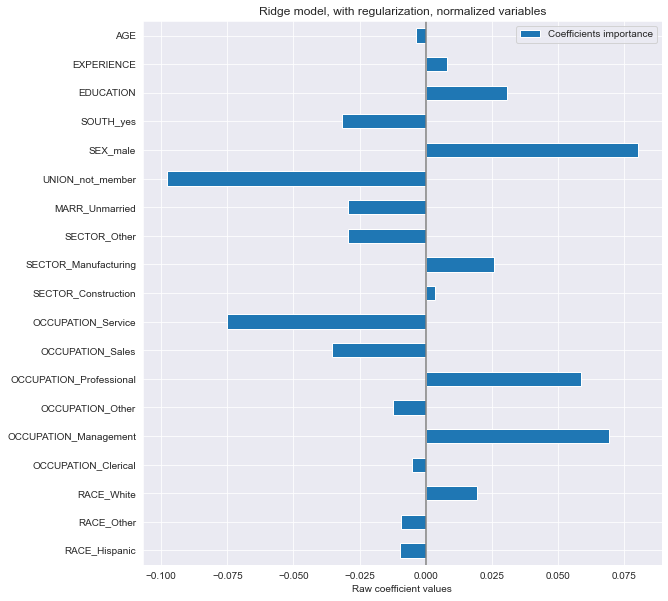

In [90]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(12, 10))
plt.title("Ridge model, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

The coefficients are significantly different. `AGE` and `EXPERIENCE` coefficients are **both positive but they now have less influence on the prediction.** The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights. On the other hand, the **weights obtained with regularization are more stable**.

In [91]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

cv_model = cross_validate(
    model, X, y,
    cv=cv,
    return_estimator=True,
    n_jobs=-1
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names
)

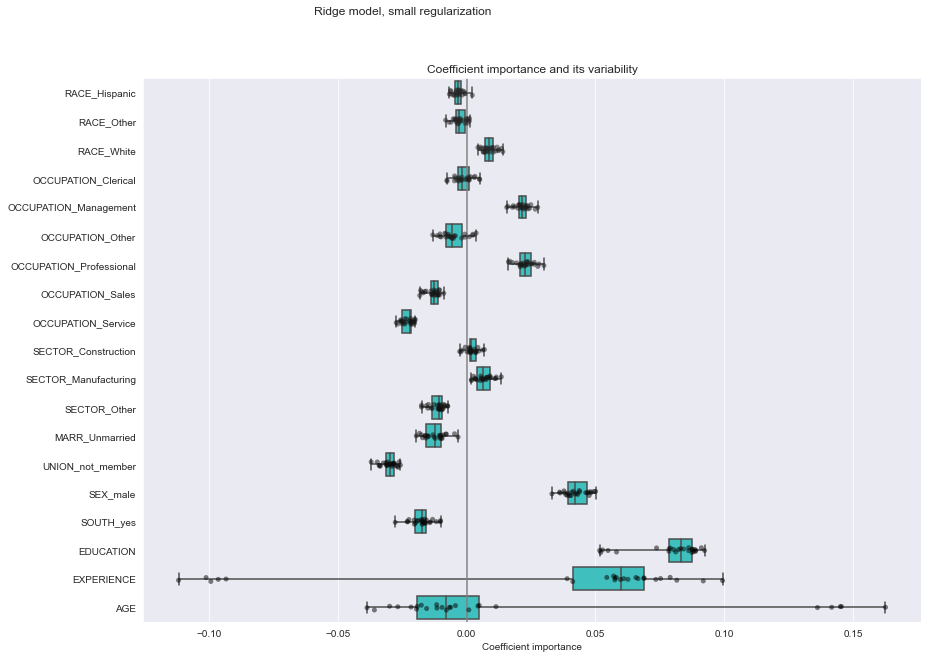

In [92]:
plt.figure(figsize=(18, 10))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

### Lessons learned¶
- Coefficients must be scaled to the same unit of measure to retrieve feature importance. Scaling them with the standard-deviation of the feature is a useful proxy.
- Correlated features induce instabilities in the coefficients of linear models and their effects cannot be well teased apart.
- Different linear models respond differently to feature correlation and coefficients could significantly vary from one another.
- Inspecting coefficients across the folds of a cross-validation loop gives an idea of their stability.
- Coefficients are unlikely to have any causal meaning. They tend to be biased by unobserved confounders.